In [ ]:
# !pip install kaggle
# from google.colab import files
# files.upload()

In [ ]:
# !ls -1ha kaggle.json

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# # Permission Warning 이 일어나지 않도록 
# !chmod 600 ~/.kaggle/kaggle.json
# # 본인이 참가한 모든 대회 보기 
# !kaggle competitions list

In [ ]:
!pip3 install tokenizers wandb sentencepiece

     |████████████████████████████████| 6.6 MB 14.8 MB/s 
     |████████████████████████████████| 1.8 MB 71.6 MB/s 
     |████████████████████████████████| 1.2 MB 61.0 MB/s 
     |████████████████████████████████| 144 kB 83.8 MB/s 
     |████████████████████████████████| 181 kB 84.3 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=6c47b78ea6ed9938ff060b33927a03c3c39fe8ad711d9b0a080021350fac8ad2
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 14.6 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 596 kB 68.3 MB/s 
     |████████████████████████████████| 880 kB 82.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=38383f166757f162bb30037c1b824326eb4e7b77b224d32cbf69979f56756b4e
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
os.chdir("drive/")
os.chdir('My Drive')
os.chdir('Kaggle')

In [ ]:
# !kaggle competitions download -c us-patent-phrase-to-phrase-matching
# !unzip us-patent-phrase-to-phrase-matching.zip
# !ls

In [ ]:
# debert_v3_tokenizer_path = 'deberta-v2-v3-fast-tokenizer'
# %env TOKENIZERS_PARALLELISM=true

# import shutil
# from pathlib import Path

# transformers_path = Path('/usr/local/lib/python3.7/dist-packages/transformers')
# input_dir = Path('./deberta-v2-v3-fast-tokenizer')

# convert_file = input_dir / "convert_slow_tokenizer.py"
# conversion_path = transformers_path / convert_file.name

# if conversion_path.exists():
#     conversion_path.unlink()

# shutil.copy(convert_file, transformers_path)
# deberta_v2_path = transformers_path / "models" / "deberta_v2"

# for filename in ['tokenization_deberta_v2.py', 'tokenization_deberta_v2_fast.py']:
#     filepath = deberta_v2_path/filename
    
#     if filepath.exists():
#         filepath.unlink()
#     shutil.copy(input_dir/filename, filepath)

In [ ]:
OUTPUT_DIR = './uspppm-deberta-v3-outputs/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May  5 11:39:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=True
    competition='PPPM'
    _wandb_kernel='bluehills'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=50
    epochs=5
    encoder_lr=2e-5 #2e-5
    decoder_lr=2e-5 #2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=10
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [ ]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    import wandb
    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        # wandb.login(key=secret_value_0)
        print('login to wandb')
        wandb.login()
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-focal_loss', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

login to wandb


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bluehills. Use `wandb login --relogin` to force relogin


# Library

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import torch.cuda.amp as amp

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoConfig, AutoModelForTokenClassification

%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)


# Data Loading

In [ ]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [ ]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('./CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'./CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [ ]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

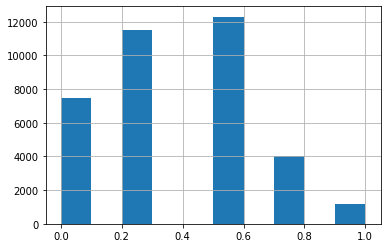

In [ ]:
train['score'].hist()

In [ ]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

# CV Split

In [ ]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    7295
1    7295
2    7295
3    7294
4    7294
dtype: int64

In [ ]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# Tokenizer

In [ ]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [ ]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

# Model

In [ ]:
class TransformerHead(nn.Module):
    def __init__(self, in_features, max_length, num_layers=1, nhead=8, num_targets=1):
        super().__init__()

        self.transformer = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(d_model=in_features, nhead=nhead),
            num_layers=num_layers)
        self.row_fc = nn.Linear(in_features, 1)
        self.out_features = max_length

    def forward(self, x):
        out = self.transformer(x)
        out = self.row_fc(out).squeeze(-1)
        return out

In [ ]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        
        self.feature_extractor = AutoModelForTokenClassification.from_pretrained(cfg.model)
        in_features = self.feature_extractor.classifier.in_features
        self.attention = TransformerHead(in_features=in_features, max_length=133, num_layers=1, nhead=8, num_targets=1)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.attention.out_features, self.cfg.target_size)
        self._init_weights(self.fc)
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        feature = self.attention(last_hidden_states)
        
        return feature


    def forward(self, inputs):
        feature = self.feature(inputs)
        #print(feature.shape)
        output = self.fc(self.fc_dropout(feature))
        return output

In [ ]:
# # ====================================================
# # Model
# # ====================================================
# class CustomModel(nn.Module):
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
#         self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
#         self._init_weights(self.fc)
#         self.attention = nn.Sequential(
#             nn.Linear(self.config.hidden_size, 512),
#             nn.Tanh(),
#             nn.Linear(512, 1),
#             nn.Softmax(dim=1)
#         )
#         self._init_weights(self.attention)
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         last_hidden_states = outputs[0]
#         # feature = torch.mean(last_hidden_states, 1)
#         weights = self.attention(last_hidden_states)
#         feature = torch.sum(weights * last_hidden_states, dim=1)
#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         output = self.fc(self.fc_dropout(feature))
#         return output


In [ ]:
class FocalLossV1(nn.Module):
    def __init__(self,
                 alpha=0.25,
                 gamma=2,
                 reduction='mean',):
        super(FocalLossV1, self).__init__()
        self.alpha = alpha
        # self.alpha = torch.tensor([alpha, 1-alpha]).cuda()
        self.gamma = gamma
        self.reduction = reduction
        self.crit = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, label):
        '''
        Usage is same as nn.BCEWithLogits:
            >>> criteria = FocalLossV1()
            >>> logits = torch.randn(8, 19, 384, 384)
            >>> lbs = torch.randint(0, 2, (8, 19, 384, 384)).float()
            >>> loss = criteria(logits, lbs)
        '''
        probs = torch.sigmoid(logits)
        coeff = torch.abs(label - probs).pow(self.gamma).neg()
        log_probs = torch.where(logits >= 0,
                F.softplus(logits, -1, 50),
                logits - F.softplus(logits, 1, 50))
        log_1_probs = torch.where(logits >= 0,
                -logits + F.softplus(logits, -1, 50),
                -F.softplus(logits, 1, 50))
        loss = label * self.alpha * log_probs + (1. - label) * (1. - self.alpha) * log_1_probs
        loss = loss * coeff

        if self.reduction == 'mean':
            loss = loss.mean()
        if self.reduction == 'sum':
            loss = loss.sum()
        return loss
        # BCE_loss = F.binary_cross_entropy_with_logits(logits, label, reduction='none')
        # targets = label.type(torch.long)
        # at = self.alpha.gather(0, targets.data.view(-1))
        # pt = torch.exp(-BCE_loss)
        # F_loss = at*(1-pt)**self.gamma * BCE_loss
        # return F_loss.mean()

# Helper Functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        # loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        # preds.append(y_preds.sigmoid().to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    # criterion = nn.BCEWithLogitsLoss(reduction="mean")
    criterion = FocalLossV1().cuda()
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
        
        torch.cuda.empty_cache()
        gc.collect()

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the 

Epoch: [1][0/2917] Elapsed 0m 0s (remain 41m 3s) Loss: 0.0395(0.0395) Grad: 57540.9570  LR: 0.00000040  
Epoch: [1][100/2917] Elapsed 0m 26s (remain 12m 16s) Loss: 0.0206(0.0260) Grad: 33961.5234  LR: 0.00002000  
Epoch: [1][200/2917] Elapsed 0m 52s (remain 11m 44s) Loss: 0.0212(0.0214) Grad: 60270.8789  LR: 0.00001999  
Epoch: [1][300/2917] Elapsed 1m 17s (remain 11m 14s) Loss: 0.0092(0.0186) Grad: 18792.7695  LR: 0.00001999  
Epoch: [1][400/2917] Elapsed 1m 43s (remain 10m 47s) Loss: 0.0083(0.0169) Grad: 18679.0488  LR: 0.00001997  
Epoch: [1][500/2917] Elapsed 2m 8s (remain 10m 21s) Loss: 0.0158(0.0156) Grad: 30010.2090  LR: 0.00001995  
Epoch: [1][600/2917] Elapsed 2m 34s (remain 9m 54s) Loss: 0.0164(0.0146) Grad: 34942.2422  LR: 0.00001993  
Epoch: [1][700/2917] Elapsed 3m 0s (remain 9m 31s) Loss: 0.0082(0.0138) Grad: 11473.5996  LR: 0.00001990  
Epoch: [1][800/2917] Elapsed 3m 26s (remain 9m 5s) Loss: 0.0117(0.0133) Grad: 59560.9805  LR: 0.00001987  
Epoch: [1][900/2917] Elapsed 

Epoch 1 - avg_train_loss: 0.0092  avg_val_loss: 0.0065  time: 831s
Epoch 1 - Score: 0.8331
Epoch 1 - Save Best Score: 0.8331 Model


EVAL: [729/730] Elapsed 1m 19s (remain 0m 0s) Loss: 0.0009(0.0065) 
Epoch: [2][0/2917] Elapsed 0m 0s (remain 29m 55s) Loss: 0.0051(0.0051) Grad: 11674.1807  LR: 0.00001814  
Epoch: [2][100/2917] Elapsed 0m 27s (remain 12m 40s) Loss: 0.0026(0.0047) Grad: 20088.9844  LR: 0.00001801  
Epoch: [2][200/2917] Elapsed 0m 53s (remain 12m 7s) Loss: 0.0050(0.0051) Grad: 11132.5000  LR: 0.00001788  
Epoch: [2][300/2917] Elapsed 1m 20s (remain 11m 36s) Loss: 0.0035(0.0048) Grad: 29348.0195  LR: 0.00001775  
Epoch: [2][400/2917] Elapsed 1m 45s (remain 11m 4s) Loss: 0.0049(0.0049) Grad: 16333.0059  LR: 0.00001761  
Epoch: [2][500/2917] Elapsed 2m 11s (remain 10m 33s) Loss: 0.0040(0.0049) Grad: 10002.2041  LR: 0.00001747  
Epoch: [2][600/2917] Elapsed 2m 37s (remain 10m 5s) Loss: 0.0065(0.0050) Grad: 8701.7305  LR: 0.00001732  
Epoch: [2][700/2917] Elapsed 3m 2s (remain 9m 38s) Loss: 0.0043(0.0050) Grad: 7229.6401  LR: 0.00001717  
Epoch: [2][800/2917] Elapsed 3m 28s (remain 9m 11s) Loss: 0.0030(0.005

Epoch 2 - avg_train_loss: 0.0048  avg_val_loss: 0.0059  time: 833s
Epoch 2 - Score: 0.8386
Epoch 2 - Save Best Score: 0.8386 Model


EVAL: [729/730] Elapsed 1m 18s (remain 0m 0s) Loss: 0.0007(0.0059) 
Epoch: [3][0/2917] Elapsed 0m 0s (remain 30m 54s) Loss: 0.0028(0.0028) Grad: 5974.9116  LR: 0.00001315  
Epoch: [3][100/2917] Elapsed 0m 27s (remain 12m 40s) Loss: 0.0007(0.0031) Grad: 2791.5486  LR: 0.00001295  
Epoch: [3][200/2917] Elapsed 0m 53s (remain 12m 8s) Loss: 0.0032(0.0033) Grad: 8959.9336  LR: 0.00001274  
Epoch: [3][300/2917] Elapsed 1m 20s (remain 11m 37s) Loss: 0.0024(0.0034) Grad: 5413.5449  LR: 0.00001253  
Epoch: [3][400/2917] Elapsed 1m 45s (remain 11m 1s) Loss: 0.0019(0.0034) Grad: 5982.5967  LR: 0.00001232  
Epoch: [3][500/2917] Elapsed 2m 10s (remain 10m 31s) Loss: 0.0063(0.0034) Grad: 21289.3809  LR: 0.00001211  
Epoch: [3][600/2917] Elapsed 2m 36s (remain 10m 2s) Loss: 0.0014(0.0035) Grad: 9189.3115  LR: 0.00001190  
Epoch: [3][700/2917] Elapsed 3m 1s (remain 9m 34s) Loss: 0.0018(0.0034) Grad: 4527.1172  LR: 0.00001169  
Epoch: [3][800/2917] Elapsed 3m 27s (remain 9m 8s) Loss: 0.0024(0.0034) Gra

Epoch 3 - avg_train_loss: 0.0034  avg_val_loss: 0.0058  time: 829s
Epoch 3 - Score: 0.8330


EVAL: [729/730] Elapsed 1m 18s (remain 0m 0s) Loss: 0.0003(0.0058) 
Epoch: [4][0/2917] Elapsed 0m 0s (remain 30m 7s) Loss: 0.0014(0.0014) Grad: 7326.5244  LR: 0.00000695  
Epoch: [4][100/2917] Elapsed 0m 26s (remain 12m 13s) Loss: 0.0009(0.0021) Grad: 5445.2168  LR: 0.00000675  
Epoch: [4][200/2917] Elapsed 0m 52s (remain 11m 47s) Loss: 0.0016(0.0024) Grad: 10977.6445  LR: 0.00000655  
Epoch: [4][300/2917] Elapsed 1m 18s (remain 11m 18s) Loss: 0.0020(0.0025) Grad: 11710.8389  LR: 0.00000634  
Epoch: [4][400/2917] Elapsed 1m 43s (remain 10m 49s) Loss: 0.0008(0.0024) Grad: 4902.9463  LR: 0.00000614  
Epoch: [4][500/2917] Elapsed 2m 9s (remain 10m 23s) Loss: 0.0032(0.0024) Grad: 9508.8594  LR: 0.00000594  
Epoch: [4][600/2917] Elapsed 2m 35s (remain 9m 57s) Loss: 0.0027(0.0024) Grad: 12313.7207  LR: 0.00000575  
Epoch: [4][700/2917] Elapsed 3m 0s (remain 9m 31s) Loss: 0.0024(0.0024) Grad: 5699.3213  LR: 0.00000555  
Epoch: [4][800/2917] Elapsed 3m 26s (remain 9m 5s) Loss: 0.0047(0.0024) G

Epoch 4 - avg_train_loss: 0.0023  avg_val_loss: 0.0060  time: 827s
Epoch 4 - Score: 0.8258


EVAL: [729/730] Elapsed 1m 18s (remain 0m 0s) Loss: 0.0001(0.0060) 
Epoch: [5][0/2917] Elapsed 0m 0s (remain 29m 52s) Loss: 0.0021(0.0021) Grad: 9361.0479  LR: 0.00000193  
Epoch: [5][100/2917] Elapsed 0m 26s (remain 12m 21s) Loss: 0.0019(0.0017) Grad: 18831.6309  LR: 0.00000180  
Epoch: [5][200/2917] Elapsed 0m 52s (remain 11m 47s) Loss: 0.0026(0.0018) Grad: 10160.2363  LR: 0.00000168  
Epoch: [5][300/2917] Elapsed 1m 17s (remain 11m 17s) Loss: 0.0004(0.0017) Grad: 2805.7529  LR: 0.00000156  
Epoch: [5][400/2917] Elapsed 1m 43s (remain 10m 49s) Loss: 0.0014(0.0017) Grad: 3249.1182  LR: 0.00000145  
Epoch: [5][500/2917] Elapsed 2m 9s (remain 10m 24s) Loss: 0.0043(0.0018) Grad: 8334.4326  LR: 0.00000134  
Epoch: [5][600/2917] Elapsed 2m 35s (remain 9m 58s) Loss: 0.0010(0.0019) Grad: 5579.1426  LR: 0.00000123  
Epoch: [5][700/2917] Elapsed 3m 0s (remain 9m 31s) Loss: 0.0031(0.0019) Grad: 8794.4160  LR: 0.00000113  
Epoch: [5][800/2917] Elapsed 3m 26s (remain 9m 6s) Loss: 0.0034(0.0018) G

Epoch 5 - avg_train_loss: 0.0019  avg_val_loss: 0.0061  time: 838s
Epoch 5 - Score: 0.8254


EVAL: [729/730] Elapsed 1m 18s (remain 0m 0s) Loss: 0.0001(0.0061) 


========== fold: 0 result ==========
Score: 0.8386
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2917] Elapsed 0m 0s (remain 30m 48s) Loss: 0.0397(0.0397) Grad: 64993.8320  LR: 0.00000040  
Epoch: [1][100/2917] Elapsed 0m 26s (remain 12m 20s) Loss: 0.0082(0.0229) Grad: 13460.7891  LR: 0.00002000  
Epoch: [1][200/2917] Elapsed 0m 52s (remain 11m 47s) Loss: 0.0180(0.0214) Grad: 13687.8799  LR: 0.00001999  
Epoch: [1][300/2917] Elapsed 1m 17s (remain 11m 17s) Loss: 0.0121(0.0207) Grad: 20043.2168  LR: 0.00001999  
Epoch: [1][400/2917] Elapsed 1m 43s (remain 10m 48s) Loss: 0.0186(0.0196) Grad: 40200.6797  LR: 0.00001997  
Epoch: [1][500/2917] Elapsed 2m 8s (remain 10m 20s) Loss: 0.0075(0.0186) Grad: 19787.4453  LR: 0.00001995  
Epoch: [1][600/2917] Elapsed 2m 34s (remain 9m 53s) Loss: 0.0136(0.0176) Grad: 51605.5273  LR: 0.00001993  
Epoch: [1][700/2917] Elapsed 2m 59s (remain 9m 26s) Loss: 0.0097(0.0166) Grad: 20879.4258  LR: 0.00001990  
Epoch: [1][800/2917] Elapsed 3m 24s (remain 9m 1s) Loss: 0.0090(0.0159) Grad: 22007.5605  LR: 0.00001987  
Epoch: [1][900/2917] Elapse

Epoch 1 - avg_train_loss: 0.0102  avg_val_loss: 0.0078  time: 830s
Epoch 1 - Score: 0.8198
Epoch 1 - Save Best Score: 0.8198 Model


EVAL: [729/730] Elapsed 1m 18s (remain 0m 0s) Loss: 0.0092(0.0078) 
Epoch: [2][0/2917] Elapsed 0m 0s (remain 34m 14s) Loss: 0.0036(0.0036) Grad: 11079.6572  LR: 0.00001814  
Epoch: [2][100/2917] Elapsed 0m 27s (remain 12m 48s) Loss: 0.0013(0.0056) Grad: 4679.3271  LR: 0.00001801  
Epoch: [2][200/2917] Elapsed 0m 54s (remain 12m 18s) Loss: 0.0070(0.0057) Grad: 20496.6074  LR: 0.00001788  
Epoch: [2][300/2917] Elapsed 1m 20s (remain 11m 43s) Loss: 0.0083(0.0056) Grad: 20545.0176  LR: 0.00001775  
Epoch: [2][400/2917] Elapsed 1m 46s (remain 11m 9s) Loss: 0.0083(0.0055) Grad: 21726.8203  LR: 0.00001761  
Epoch: [2][500/2917] Elapsed 2m 12s (remain 10m 39s) Loss: 0.0067(0.0055) Grad: 13559.1338  LR: 0.00001747  
Epoch: [2][600/2917] Elapsed 2m 38s (remain 10m 9s) Loss: 0.0022(0.0055) Grad: 11921.6895  LR: 0.00001732  
Epoch: [2][700/2917] Elapsed 3m 3s (remain 9m 40s) Loss: 0.0042(0.0056) Grad: 9961.3496  LR: 0.00001717  
Epoch: [2][800/2917] Elapsed 3m 29s (remain 9m 12s) Loss: 0.0026(0.00

Epoch 2 - avg_train_loss: 0.0054  avg_val_loss: 0.0066  time: 832s
Epoch 2 - Score: 0.8179


EVAL: [729/730] Elapsed 1m 19s (remain 0m 0s) Loss: 0.0034(0.0066) 
Epoch: [3][0/2917] Elapsed 0m 0s (remain 31m 22s) Loss: 0.0031(0.0031) Grad: 8830.9590  LR: 0.00001315  
Epoch: [3][100/2917] Elapsed 0m 26s (remain 12m 31s) Loss: 0.0030(0.0034) Grad: 21011.7520  LR: 0.00001295  
Epoch: [3][200/2917] Elapsed 0m 53s (remain 12m 7s) Loss: 0.0031(0.0035) Grad: 8150.0752  LR: 0.00001274  
Epoch: [3][300/2917] Elapsed 1m 20s (remain 11m 40s) Loss: 0.0021(0.0036) Grad: 9230.5645  LR: 0.00001253  
Epoch: [3][400/2917] Elapsed 1m 47s (remain 11m 12s) Loss: 0.0024(0.0036) Grad: 4896.7812  LR: 0.00001232  
Epoch: [3][500/2917] Elapsed 2m 13s (remain 10m 45s) Loss: 0.0004(0.0037) Grad: 2977.3845  LR: 0.00001211  
Epoch: [3][600/2917] Elapsed 2m 40s (remain 10m 17s) Loss: 0.0081(0.0037) Grad: 23952.2695  LR: 0.00001190  
Epoch: [3][700/2917] Elapsed 3m 6s (remain 9m 49s) Loss: 0.0024(0.0037) Grad: 7509.4492  LR: 0.00001169  
Epoch: [3][800/2917] Elapsed 3m 32s (remain 9m 22s) Loss: 0.0021(0.0037)

Epoch 3 - avg_train_loss: 0.0036  avg_val_loss: 0.0067  time: 852s
Epoch 3 - Score: 0.8250
Epoch 3 - Save Best Score: 0.8250 Model


EVAL: [729/730] Elapsed 1m 18s (remain 0m 0s) Loss: 0.0029(0.0067) 
Epoch: [4][0/2917] Elapsed 0m 0s (remain 33m 15s) Loss: 0.0007(0.0007) Grad: 5573.6895  LR: 0.00000695  
Epoch: [4][100/2917] Elapsed 0m 27s (remain 12m 54s) Loss: 0.0025(0.0028) Grad: 4854.0278  LR: 0.00000675  
Epoch: [4][200/2917] Elapsed 0m 55s (remain 12m 25s) Loss: 0.0009(0.0026) Grad: 6178.6367  LR: 0.00000655  
Epoch: [4][300/2917] Elapsed 1m 22s (remain 11m 53s) Loss: 0.0044(0.0027) Grad: 7660.7231  LR: 0.00000634  
Epoch: [4][400/2917] Elapsed 1m 48s (remain 11m 18s) Loss: 0.0023(0.0026) Grad: 21035.8770  LR: 0.00000614  
Epoch: [4][500/2917] Elapsed 2m 13s (remain 10m 45s) Loss: 0.0022(0.0028) Grad: 6107.9927  LR: 0.00000594  
Epoch: [4][600/2917] Elapsed 2m 39s (remain 10m 16s) Loss: 0.0009(0.0027) Grad: 7040.0264  LR: 0.00000575  
Epoch: [4][700/2917] Elapsed 3m 5s (remain 9m 47s) Loss: 0.0020(0.0027) Grad: 5209.6968  LR: 0.00000555  
Epoch: [4][800/2917] Elapsed 3m 31s (remain 9m 18s) Loss: 0.0060(0.0027)

Epoch 4 - avg_train_loss: 0.0025  avg_val_loss: 0.0063  time: 850s
Epoch 4 - Score: 0.8166


EVAL: [729/730] Elapsed 1m 18s (remain 0m 0s) Loss: 0.0002(0.0063) 
Epoch: [5][0/2917] Elapsed 0m 0s (remain 31m 9s) Loss: 0.0021(0.0021) Grad: 5777.3311  LR: 0.00000193  
Epoch: [5][100/2917] Elapsed 0m 26s (remain 12m 30s) Loss: 0.0004(0.0019) Grad: 3157.3630  LR: 0.00000180  
Epoch: [5][200/2917] Elapsed 0m 53s (remain 12m 2s) Loss: 0.0042(0.0020) Grad: 6433.5850  LR: 0.00000168  
Epoch: [5][300/2917] Elapsed 1m 20s (remain 11m 37s) Loss: 0.0007(0.0020) Grad: 6042.2969  LR: 0.00000156  
Epoch: [5][400/2917] Elapsed 1m 46s (remain 11m 11s) Loss: 0.0018(0.0021) Grad: 4738.5425  LR: 0.00000145  
Epoch: [5][500/2917] Elapsed 2m 13s (remain 10m 45s) Loss: 0.0012(0.0021) Grad: 5766.0293  LR: 0.00000134  
Epoch: [5][600/2917] Elapsed 2m 40s (remain 10m 18s) Loss: 0.0023(0.0021) Grad: 11225.4434  LR: 0.00000123  
Epoch: [5][700/2917] Elapsed 3m 7s (remain 9m 52s) Loss: 0.0026(0.0021) Grad: 6517.3438  LR: 0.00000113  
Epoch: [5][800/2917] Elapsed 3m 34s (remain 9m 25s) Loss: 0.0044(0.0021) G

Epoch 5 - avg_train_loss: 0.0020  avg_val_loss: 0.0066  time: 861s
Epoch 5 - Score: 0.8165


EVAL: [729/730] Elapsed 1m 19s (remain 0m 0s) Loss: 0.0003(0.0066) 


========== fold: 1 result ==========
Score: 0.8250
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2917] Elapsed 0m 0s (remain 28m 47s) Loss: 0.0620(0.0620) Grad: 29695.9980  LR: 0.00000040  
Epoch: [1][100/2917] Elapsed 0m 27s (remain 12m 44s) Loss: 0.0297(0.0286) Grad: 49957.9844  LR: 0.00002000  
Epoch: [1][200/2917] Elapsed 0m 53s (remain 12m 6s) Loss: 0.0402(0.0242) Grad: 24375.2051  LR: 0.00001999  
Epoch: [1][300/2917] Elapsed 1m 20s (remain 11m 38s) Loss: 0.0081(0.0230) Grad: 22820.4727  LR: 0.00001999  
Epoch: [1][400/2917] Elapsed 1m 46s (remain 11m 10s) Loss: 0.0286(0.0221) Grad: 71129.2031  LR: 0.00001997  
Epoch: [1][500/2917] Elapsed 2m 13s (remain 10m 43s) Loss: 0.0140(0.0206) Grad: 35975.9375  LR: 0.00001995  
Epoch: [1][600/2917] Elapsed 2m 40s (remain 10m 16s) Loss: 0.0051(0.0191) Grad: 13325.4912  LR: 0.00001993  
Epoch: [1][700/2917] Elapsed 3m 6s (remain 9m 49s) Loss: 0.0121(0.0181) Grad: 40465.4805  LR: 0.00001990  
Epoch: [1][800/2917] Elapsed 3m 33s (remain 9m 22s) Loss: 0.0093(0.0172) Grad: 32831.9922  LR: 0.00001987  
Epoch: [1][900/2917] Elaps

Epoch 1 - avg_train_loss: 0.0106  avg_val_loss: 0.0077  time: 850s
Epoch 1 - Score: 0.8022
Epoch 1 - Save Best Score: 0.8022 Model


EVAL: [729/730] Elapsed 1m 18s (remain 0m 0s) Loss: 0.0197(0.0077) 
Epoch: [2][0/2917] Elapsed 0m 3s (remain 171m 13s) Loss: 0.0221(0.0221) Grad: 29713.1055  LR: 0.00001814  
Epoch: [2][100/2917] Elapsed 0m 30s (remain 14m 18s) Loss: 0.0030(0.0053) Grad: 6935.9580  LR: 0.00001801  
Epoch: [2][200/2917] Elapsed 0m 58s (remain 13m 6s) Loss: 0.0034(0.0054) Grad: 21807.8145  LR: 0.00001788  
Epoch: [2][300/2917] Elapsed 1m 25s (remain 12m 22s) Loss: 0.0078(0.0053) Grad: 30751.7695  LR: 0.00001775  
Epoch: [2][400/2917] Elapsed 1m 51s (remain 11m 39s) Loss: 0.0040(0.0056) Grad: 11034.3623  LR: 0.00001761  
Epoch: [2][500/2917] Elapsed 2m 17s (remain 11m 4s) Loss: 0.0096(0.0055) Grad: 20636.2383  LR: 0.00001747  
Epoch: [2][600/2917] Elapsed 2m 44s (remain 10m 32s) Loss: 0.0187(0.0056) Grad: 138420.2031  LR: 0.00001732  
Epoch: [2][700/2917] Elapsed 3m 10s (remain 10m 3s) Loss: 0.0048(0.0055) Grad: 10042.6738  LR: 0.00001717  
Epoch: [2][800/2917] Elapsed 3m 36s (remain 9m 33s) Loss: 0.0055(

Epoch 2 - avg_train_loss: 0.0055  avg_val_loss: 0.0061  time: 856s
Epoch 2 - Score: 0.8195
Epoch 2 - Save Best Score: 0.8195 Model


EVAL: [729/730] Elapsed 1m 18s (remain 0m 0s) Loss: 0.0081(0.0061) 
Epoch: [3][0/2917] Elapsed 0m 0s (remain 32m 58s) Loss: 0.0024(0.0024) Grad: 5493.8076  LR: 0.00001315  
Epoch: [3][100/2917] Elapsed 0m 27s (remain 12m 52s) Loss: 0.0053(0.0034) Grad: 13994.2461  LR: 0.00001295  
Epoch: [3][200/2917] Elapsed 0m 55s (remain 12m 26s) Loss: 0.0075(0.0037) Grad: 31011.6309  LR: 0.00001274  
Epoch: [3][300/2917] Elapsed 1m 22s (remain 11m 56s) Loss: 0.0018(0.0036) Grad: 6452.3687  LR: 0.00001253  
Epoch: [3][400/2917] Elapsed 1m 49s (remain 11m 24s) Loss: 0.0009(0.0038) Grad: 5809.6377  LR: 0.00001232  
Epoch: [3][500/2917] Elapsed 2m 15s (remain 10m 52s) Loss: 0.0009(0.0038) Grad: 5954.0293  LR: 0.00001211  
Epoch: [3][600/2917] Elapsed 2m 41s (remain 10m 24s) Loss: 0.0091(0.0039) Grad: 25011.5703  LR: 0.00001190  
Epoch: [3][700/2917] Elapsed 3m 8s (remain 9m 56s) Loss: 0.0010(0.0038) Grad: 5463.0874  LR: 0.00001169  
Epoch: [3][800/2917] Elapsed 3m 35s (remain 9m 27s) Loss: 0.0030(0.003

Epoch 3 - avg_train_loss: 0.0037  avg_val_loss: 0.0065  time: 856s
Epoch 3 - Score: 0.8249
Epoch 3 - Save Best Score: 0.8249 Model


EVAL: [729/730] Elapsed 1m 19s (remain 0m 0s) Loss: 0.0086(0.0065) 
Epoch: [4][0/2917] Elapsed 0m 0s (remain 34m 47s) Loss: 0.0035(0.0035) Grad: 7696.7773  LR: 0.00000695  
Epoch: [4][100/2917] Elapsed 0m 28s (remain 13m 17s) Loss: 0.0025(0.0029) Grad: 7795.3232  LR: 0.00000675  
Epoch: [4][200/2917] Elapsed 0m 56s (remain 12m 42s) Loss: 0.0024(0.0027) Grad: 5420.3188  LR: 0.00000655  
Epoch: [4][300/2917] Elapsed 1m 23s (remain 12m 5s) Loss: 0.0019(0.0029) Grad: 12628.9941  LR: 0.00000634  
Epoch: [4][400/2917] Elapsed 1m 49s (remain 11m 29s) Loss: 0.0023(0.0029) Grad: 8735.5479  LR: 0.00000614  
Epoch: [4][500/2917] Elapsed 2m 16s (remain 10m 57s) Loss: 0.0041(0.0028) Grad: 6712.5586  LR: 0.00000594  
Epoch: [4][600/2917] Elapsed 2m 43s (remain 10m 28s) Loss: 0.0012(0.0027) Grad: 11313.8076  LR: 0.00000575  
Epoch: [4][700/2917] Elapsed 3m 9s (remain 9m 59s) Loss: 0.0003(0.0028) Grad: 3036.6038  LR: 0.00000555  
Epoch: [4][800/2917] Elapsed 3m 36s (remain 9m 31s) Loss: 0.0016(0.0027)

Epoch 4 - avg_train_loss: 0.0026  avg_val_loss: 0.0066  time: 855s
Epoch 4 - Score: 0.8178


EVAL: [729/730] Elapsed 1m 19s (remain 0m 0s) Loss: 0.0050(0.0066) 
Epoch: [5][0/2917] Elapsed 0m 0s (remain 30m 19s) Loss: 0.0094(0.0094) Grad: 14172.2666  LR: 0.00000193  
Epoch: [5][100/2917] Elapsed 0m 27s (remain 12m 37s) Loss: 0.0001(0.0021) Grad: 1991.9622  LR: 0.00000180  
Epoch: [5][200/2917] Elapsed 0m 53s (remain 12m 0s) Loss: 0.0015(0.0021) Grad: 6348.5396  LR: 0.00000168  
Epoch: [5][300/2917] Elapsed 1m 19s (remain 11m 30s) Loss: 0.0011(0.0020) Grad: 8697.1768  LR: 0.00000156  
Epoch: [5][400/2917] Elapsed 1m 46s (remain 11m 5s) Loss: 0.0024(0.0021) Grad: 11386.2734  LR: 0.00000145  
Epoch: [5][500/2917] Elapsed 2m 13s (remain 10m 42s) Loss: 0.0011(0.0020) Grad: 5098.9624  LR: 0.00000134  
Epoch: [5][600/2917] Elapsed 2m 40s (remain 10m 17s) Loss: 0.0003(0.0021) Grad: 1621.7648  LR: 0.00000123  
Epoch: [5][700/2917] Elapsed 3m 7s (remain 9m 51s) Loss: 0.0074(0.0021) Grad: 45829.5312  LR: 0.00000113  
Epoch: [5][800/2917] Elapsed 3m 33s (remain 9m 24s) Loss: 0.0041(0.0021)

Epoch 5 - avg_train_loss: 0.0021  avg_val_loss: 0.0069  time: 854s
Epoch 5 - Score: 0.8176


EVAL: [729/730] Elapsed 1m 19s (remain 0m 0s) Loss: 0.0047(0.0069) 


========== fold: 2 result ==========
Score: 0.8249
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2917] Elapsed 0m 0s (remain 29m 50s) Loss: 0.0643(0.0643) Grad: 74131.9141  LR: 0.00000040  
Epoch: [1][100/2917] Elapsed 0m 26s (remain 12m 21s) Loss: 0.0186(0.0245) Grad: 21126.9766  LR: 0.00002000  
Epoch: [1][200/2917] Elapsed 0m 52s (remain 11m 48s) Loss: 0.0101(0.0213) Grad: 12931.5459  LR: 0.00001999  
Epoch: [1][300/2917] Elapsed 1m 17s (remain 11m 17s) Loss: 0.0171(0.0188) Grad: 32500.3340  LR: 0.00001999  
Epoch: [1][400/2917] Elapsed 1m 43s (remain 10m 49s) Loss: 0.0154(0.0171) Grad: 47811.1680  LR: 0.00001997  
Epoch: [1][500/2917] Elapsed 2m 9s (remain 10m 24s) Loss: 0.0027(0.0158) Grad: 4176.0132  LR: 0.00001995  
Epoch: [1][600/2917] Elapsed 2m 35s (remain 9m 58s) Loss: 0.0156(0.0151) Grad: 12159.0039  LR: 0.00001993  
Epoch: [1][700/2917] Elapsed 3m 1s (remain 9m 33s) Loss: 0.0167(0.0145) Grad: 26502.7246  LR: 0.00001990  
Epoch: [1][800/2917] Elapsed 3m 27s (remain 9m 6s) Loss: 0.0217(0.0139) Grad: 33063.4570  LR: 0.00001987  
Epoch: [1][900/2917] Elapsed 

Epoch 1 - avg_train_loss: 0.0095  avg_val_loss: 0.0065  time: 838s
Epoch 1 - Score: 0.8172
Epoch 1 - Save Best Score: 0.8172 Model


EVAL: [729/730] Elapsed 1m 18s (remain 0m 0s) Loss: 0.0002(0.0065) 
Epoch: [2][0/2917] Elapsed 0m 0s (remain 32m 50s) Loss: 0.0120(0.0120) Grad: 14418.2275  LR: 0.00001814  
Epoch: [2][100/2917] Elapsed 0m 28s (remain 13m 15s) Loss: 0.0012(0.0047) Grad: 2497.4514  LR: 0.00001801  
Epoch: [2][200/2917] Elapsed 0m 56s (remain 12m 47s) Loss: 0.0032(0.0047) Grad: 8373.4902  LR: 0.00001788  
Epoch: [2][300/2917] Elapsed 1m 23s (remain 12m 8s) Loss: 0.0048(0.0047) Grad: 9306.7773  LR: 0.00001775  
Epoch: [2][400/2917] Elapsed 1m 50s (remain 11m 35s) Loss: 0.0025(0.0045) Grad: 7976.9443  LR: 0.00001761  
Epoch: [2][500/2917] Elapsed 2m 17s (remain 11m 5s) Loss: 0.0100(0.0046) Grad: 14707.2930  LR: 0.00001747  
Epoch: [2][600/2917] Elapsed 2m 44s (remain 10m 35s) Loss: 0.0066(0.0045) Grad: 8287.5176  LR: 0.00001732  
Epoch: [2][700/2917] Elapsed 3m 12s (remain 10m 7s) Loss: 0.0061(0.0045) Grad: 36722.6797  LR: 0.00001717  
Epoch: [2][800/2917] Elapsed 3m 39s (remain 9m 38s) Loss: 0.0071(0.0045

Epoch 2 - avg_train_loss: 0.0046  avg_val_loss: 0.0060  time: 868s
Epoch 2 - Score: 0.8072


EVAL: [729/730] Elapsed 1m 18s (remain 0m 0s) Loss: 0.0012(0.0060) 
Epoch: [3][0/2917] Elapsed 0m 0s (remain 30m 41s) Loss: 0.0032(0.0032) Grad: 7231.1577  LR: 0.00001315  
Epoch: [3][100/2917] Elapsed 0m 27s (remain 12m 41s) Loss: 0.0039(0.0032) Grad: 8898.3018  LR: 0.00001295  
Epoch: [3][200/2917] Elapsed 0m 54s (remain 12m 12s) Loss: 0.0021(0.0030) Grad: 5060.3232  LR: 0.00001274  
Epoch: [3][300/2917] Elapsed 1m 21s (remain 11m 45s) Loss: 0.0037(0.0031) Grad: 9777.0391  LR: 0.00001253  
Epoch: [3][400/2917] Elapsed 1m 47s (remain 11m 16s) Loss: 0.0009(0.0032) Grad: 4377.8242  LR: 0.00001232  
Epoch: [3][500/2917] Elapsed 2m 14s (remain 10m 49s) Loss: 0.0015(0.0032) Grad: 6338.6382  LR: 0.00001211  
Epoch: [3][600/2917] Elapsed 2m 41s (remain 10m 21s) Loss: 0.0031(0.0032) Grad: 9826.5840  LR: 0.00001190  
Epoch: [3][700/2917] Elapsed 3m 8s (remain 9m 55s) Loss: 0.0024(0.0032) Grad: 6377.3833  LR: 0.00001169  
Epoch: [3][800/2917] Elapsed 3m 35s (remain 9m 28s) Loss: 0.0030(0.0032) 

Epoch 3 - avg_train_loss: 0.0032  avg_val_loss: 0.0065  time: 861s
Epoch 3 - Score: 0.8171


EVAL: [729/730] Elapsed 1m 19s (remain 0m 0s) Loss: 0.0002(0.0065) 
Epoch: [4][0/2917] Elapsed 0m 0s (remain 31m 0s) Loss: 0.0005(0.0005) Grad: 3609.1309  LR: 0.00000695  
Epoch: [4][100/2917] Elapsed 0m 27s (remain 12m 38s) Loss: 0.0012(0.0024) Grad: 5244.5781  LR: 0.00000675  
Epoch: [4][200/2917] Elapsed 0m 53s (remain 12m 7s) Loss: 0.0006(0.0022) Grad: 4743.7910  LR: 0.00000655  
Epoch: [4][300/2917] Elapsed 1m 20s (remain 11m 41s) Loss: 0.0014(0.0022) Grad: 8630.4756  LR: 0.00000634  
Epoch: [4][400/2917] Elapsed 1m 47s (remain 11m 13s) Loss: 0.0011(0.0023) Grad: 5044.1152  LR: 0.00000614  
Epoch: [4][500/2917] Elapsed 2m 14s (remain 10m 46s) Loss: 0.0010(0.0023) Grad: 5491.7578  LR: 0.00000594  
Epoch: [4][600/2917] Elapsed 2m 40s (remain 10m 18s) Loss: 0.0057(0.0023) Grad: 11803.8018  LR: 0.00000575  
Epoch: [4][700/2917] Elapsed 3m 7s (remain 9m 52s) Loss: 0.0035(0.0024) Grad: 21328.8730  LR: 0.00000555  
Epoch: [4][800/2917] Elapsed 3m 34s (remain 9m 25s) Loss: 0.0006(0.0023) 

Epoch 4 - avg_train_loss: 0.0023  avg_val_loss: 0.0065  time: 861s
Epoch 4 - Score: 0.8102


EVAL: [729/730] Elapsed 1m 18s (remain 0m 0s) Loss: 0.0001(0.0065) 
Epoch: [5][0/2917] Elapsed 0m 0s (remain 32m 25s) Loss: 0.0014(0.0014) Grad: 5504.5728  LR: 0.00000193  
Epoch: [5][100/2917] Elapsed 0m 27s (remain 12m 47s) Loss: 0.0001(0.0019) Grad: 1544.5752  LR: 0.00000180  
Epoch: [5][200/2917] Elapsed 0m 54s (remain 12m 14s) Loss: 0.0018(0.0019) Grad: 11161.3711  LR: 0.00000168  
Epoch: [5][300/2917] Elapsed 1m 21s (remain 11m 45s) Loss: 0.0012(0.0019) Grad: 7764.0532  LR: 0.00000156  
Epoch: [5][400/2917] Elapsed 1m 47s (remain 11m 16s) Loss: 0.0014(0.0019) Grad: 11741.5459  LR: 0.00000145  
Epoch: [5][500/2917] Elapsed 2m 14s (remain 10m 50s) Loss: 0.0029(0.0019) Grad: 23714.1641  LR: 0.00000134  
Epoch: [5][600/2917] Elapsed 2m 41s (remain 10m 22s) Loss: 0.0005(0.0019) Grad: 2924.3599  LR: 0.00000123  
Epoch: [5][700/2917] Elapsed 3m 8s (remain 9m 54s) Loss: 0.0013(0.0019) Grad: 7649.2930  LR: 0.00000113  
Epoch: [5][800/2917] Elapsed 3m 34s (remain 9m 27s) Loss: 0.0002(0.001

Epoch 5 - avg_train_loss: 0.0018  avg_val_loss: 0.0069  time: 857s
Epoch 5 - Score: 0.8091


EVAL: [729/730] Elapsed 1m 18s (remain 0m 0s) Loss: 0.0002(0.0069) 


========== fold: 3 result ==========
Score: 0.8172
========== fold: 4 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2917] Elapsed 0m 0s (remain 31m 12s) Loss: 0.0258(0.0258) Grad: 21535.4492  LR: 0.00000040  
Epoch: [1][100/2917] Elapsed 0m 26s (remain 12m 27s) Loss: 0.0157(0.0248) Grad: 43444.0469  LR: 0.00002000  
Epoch: [1][200/2917] Elapsed 0m 52s (remain 11m 55s) Loss: 0.0148(0.0232) Grad: 13733.3223  LR: 0.00001999  
Epoch: [1][300/2917] Elapsed 1m 19s (remain 11m 28s) Loss: 0.0112(0.0219) Grad: 12893.9072  LR: 0.00001999  
Epoch: [1][400/2917] Elapsed 1m 45s (remain 10m 59s) Loss: 0.0126(0.0200) Grad: 17329.8789  LR: 0.00001997  
Epoch: [1][500/2917] Elapsed 2m 11s (remain 10m 34s) Loss: 0.0089(0.0183) Grad: 16203.1221  LR: 0.00001995  
Epoch: [1][600/2917] Elapsed 2m 37s (remain 10m 8s) Loss: 0.0107(0.0172) Grad: 21685.6855  LR: 0.00001993  
Epoch: [1][700/2917] Elapsed 3m 4s (remain 9m 43s) Loss: 0.0200(0.0162) Grad: 39326.2930  LR: 0.00001990  
Epoch: [1][800/2917] Elapsed 3m 31s (remain 9m 17s) Loss: 0.0118(0.0154) Grad: 36692.0977  LR: 0.00001987  
Epoch: [1][900/2917] Elaps

Epoch 1 - avg_train_loss: 0.0101  avg_val_loss: 0.0071  time: 850s
Epoch 1 - Score: 0.8126
Epoch 1 - Save Best Score: 0.8126 Model


EVAL: [729/730] Elapsed 1m 19s (remain 0m 0s) Loss: 0.0021(0.0071) 
Epoch: [2][0/2917] Elapsed 0m 0s (remain 34m 33s) Loss: 0.0083(0.0083) Grad: 13501.2402  LR: 0.00001814  
Epoch: [2][100/2917] Elapsed 0m 27s (remain 12m 58s) Loss: 0.0010(0.0051) Grad: 6424.7944  LR: 0.00001801  
Epoch: [2][200/2917] Elapsed 0m 55s (remain 12m 30s) Loss: 0.0029(0.0054) Grad: 5593.1099  LR: 0.00001788  
Epoch: [2][300/2917] Elapsed 1m 23s (remain 12m 1s) Loss: 0.0047(0.0056) Grad: 9292.2490  LR: 0.00001775  
Epoch: [2][400/2917] Elapsed 1m 49s (remain 11m 25s) Loss: 0.0062(0.0055) Grad: 13253.3174  LR: 0.00001761  
Epoch: [2][500/2917] Elapsed 2m 15s (remain 10m 53s) Loss: 0.0052(0.0055) Grad: 17107.7188  LR: 0.00001747  
Epoch: [2][600/2917] Elapsed 2m 42s (remain 10m 24s) Loss: 0.0030(0.0055) Grad: 9472.4326  LR: 0.00001732  
Epoch: [2][700/2917] Elapsed 3m 8s (remain 9m 56s) Loss: 0.0069(0.0055) Grad: 11112.4463  LR: 0.00001717  
Epoch: [2][800/2917] Elapsed 3m 35s (remain 9m 28s) Loss: 0.0018(0.005

Epoch 2 - avg_train_loss: 0.0053  avg_val_loss: 0.0057  time: 857s
Epoch 2 - Score: 0.8201
Epoch 2 - Save Best Score: 0.8201 Model


EVAL: [729/730] Elapsed 1m 18s (remain 0m 0s) Loss: 0.0044(0.0057) 
Epoch: [3][0/2917] Elapsed 0m 0s (remain 35m 0s) Loss: 0.0021(0.0021) Grad: 3719.4521  LR: 0.00001315  
Epoch: [3][100/2917] Elapsed 0m 28s (remain 13m 8s) Loss: 0.0017(0.0034) Grad: 4531.4282  LR: 0.00001295  
Epoch: [3][200/2917] Elapsed 0m 55s (remain 12m 36s) Loss: 0.0032(0.0035) Grad: 12259.6992  LR: 0.00001274  
Epoch: [3][300/2917] Elapsed 1m 23s (remain 12m 7s) Loss: 0.0020(0.0034) Grad: 4785.5728  LR: 0.00001253  
Epoch: [3][400/2917] Elapsed 1m 50s (remain 11m 32s) Loss: 0.0051(0.0036) Grad: 6210.2520  LR: 0.00001232  
Epoch: [3][500/2917] Elapsed 2m 16s (remain 10m 58s) Loss: 0.0031(0.0036) Grad: 9747.1768  LR: 0.00001211  
Epoch: [3][600/2917] Elapsed 2m 42s (remain 10m 25s) Loss: 0.0033(0.0036) Grad: 13803.9434  LR: 0.00001190  
Epoch: [3][700/2917] Elapsed 3m 9s (remain 9m 57s) Loss: 0.0017(0.0036) Grad: 4046.4275  LR: 0.00001169  
Epoch: [3][800/2917] Elapsed 3m 36s (remain 9m 30s) Loss: 0.0012(0.0036) G

Epoch 3 - avg_train_loss: 0.0035  avg_val_loss: 0.0060  time: 855s
Epoch 3 - Score: 0.8198


EVAL: [729/730] Elapsed 1m 19s (remain 0m 0s) Loss: 0.0019(0.0060) 
Epoch: [4][0/2917] Elapsed 0m 0s (remain 32m 37s) Loss: 0.0018(0.0018) Grad: 6092.2280  LR: 0.00000695  
Epoch: [4][100/2917] Elapsed 0m 27s (remain 12m 49s) Loss: 0.0024(0.0023) Grad: 6458.5532  LR: 0.00000675  
Epoch: [4][200/2917] Elapsed 0m 54s (remain 12m 15s) Loss: 0.0007(0.0022) Grad: 3726.2756  LR: 0.00000655  
Epoch: [4][300/2917] Elapsed 1m 21s (remain 11m 44s) Loss: 0.0005(0.0024) Grad: 3719.3245  LR: 0.00000634  
Epoch: [4][400/2917] Elapsed 1m 47s (remain 11m 15s) Loss: 0.0007(0.0025) Grad: 4652.0649  LR: 0.00000614  
Epoch: [4][500/2917] Elapsed 2m 14s (remain 10m 48s) Loss: 0.0021(0.0024) Grad: 6289.2866  LR: 0.00000594  
Epoch: [4][600/2917] Elapsed 2m 41s (remain 10m 20s) Loss: 0.0026(0.0025) Grad: 6271.6543  LR: 0.00000575  
Epoch: [4][700/2917] Elapsed 3m 7s (remain 9m 53s) Loss: 0.0015(0.0025) Grad: 5030.8691  LR: 0.00000555  
Epoch: [4][800/2917] Elapsed 3m 34s (remain 9m 27s) Loss: 0.0007(0.0025) 

Epoch 4 - avg_train_loss: 0.0024  avg_val_loss: 0.0061  time: 859s
Epoch 4 - Score: 0.8131


EVAL: [729/730] Elapsed 1m 19s (remain 0m 0s) Loss: 0.0024(0.0061) 
Epoch: [5][0/2917] Elapsed 0m 0s (remain 33m 25s) Loss: 0.0016(0.0016) Grad: 7461.2915  LR: 0.00000193  
Epoch: [5][100/2917] Elapsed 0m 27s (remain 12m 55s) Loss: 0.0014(0.0020) Grad: 4144.7212  LR: 0.00000180  
Epoch: [5][200/2917] Elapsed 0m 54s (remain 12m 18s) Loss: 0.0023(0.0022) Grad: 7017.9634  LR: 0.00000168  
Epoch: [5][300/2917] Elapsed 1m 21s (remain 11m 47s) Loss: 0.0021(0.0020) Grad: 9227.9629  LR: 0.00000156  
Epoch: [5][400/2917] Elapsed 1m 48s (remain 11m 17s) Loss: 0.0004(0.0020) Grad: 2531.0139  LR: 0.00000145  
Epoch: [5][500/2917] Elapsed 2m 14s (remain 10m 49s) Loss: 0.0007(0.0019) Grad: 6612.2695  LR: 0.00000134  
Epoch: [5][600/2917] Elapsed 2m 41s (remain 10m 21s) Loss: 0.0008(0.0019) Grad: 2702.9673  LR: 0.00000123  
Epoch: [5][700/2917] Elapsed 3m 7s (remain 9m 53s) Loss: 0.0016(0.0019) Grad: 5448.8032  LR: 0.00000113  
Epoch: [5][800/2917] Elapsed 3m 34s (remain 9m 25s) Loss: 0.0013(0.0019) 

Epoch 5 - avg_train_loss: 0.0019  avg_val_loss: 0.0065  time: 860s
Epoch 5 - Score: 0.8142


EVAL: [729/730] Elapsed 1m 18s (remain 0m 0s) Loss: 0.0022(0.0065) 


========== fold: 4 result ==========
Score: 0.8201
========== CV ==========
Score: 0.8190


[fold0] avg_train_loss,█▄▂▁▁
[fold0] avg_val_loss,█▂▁▃▄
[fold0] epoch,▁▃▅▆█
[fold0] loss,▆▃▄▄▃▃▂█▂▃▃▂▃▂▁▂▁▂▁▂▃▂▁▁▂▂▁▂▁▂▂▂▁▁▃▁▁▁▁▄
[fold0] lr,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▅█▅▁▁
[fold1] avg_train_loss,█▄▂▁▁
[fold1] avg_val_loss,█▂▃▁▂
[fold1] epoch,▁▃▅▆█
[fold1] loss,█▄▃▃▂▂▂▂▁▂▂▂▃▂▃▃▁▃▁▂▃▂▁▁▁▁▁▁▁▂▁▁▁▁▂▂▁▁▁▁
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
